# Calvin Knowles
# CNN Cancer Detection Mini-Project
# December 2025

## Imports

In [15]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

print("TF version:", tf.__version__)

TF version: 2.13.0


# Introduction

This project tackles the Histopathologic Cancer Detection problem from Kaggle, where the objective is to identify metastatic cancer in small 96×96 histopathology patches. Each image is labeled as either containing tumor tissue (1) or not (0), and the task is framed as a binary classification problem.

The dataset consists of over 220,000 training patches extracted from lymph node tissue in the PatchCamelyon (PCam) dataset. Images vary widely in staining intensity, color distribution, tissue structure, and cell density, making this a challenging pattern-recognition task that benefits from both strong feature extractors and robust augmentation.

### Goal
Develop and compare two supervised deep learning approaches:
1. A custom convolutional neural network (CNN) trained from scratch.
2. A transfer learning model based on EfficientNetB0 with ImageNet pretrained weights.

The goal is to understand how well a smaller custom architecture performs relative to a modern pretrained backbone, and to evaluate whether fine-tuning improves transfer learning on medical imagery.

### Methods at a Glance
To structure the workflow, the notebook proceeds through:
- **Data Loading & Preprocessing:** Reading training labels, mapping IDs to `.tif` files, and constructing image generators with augmentation.
- **EDA:** Visual inspection of patches and label distribution to confirm dataset integrity.
- **Baseline Model:** Implementing and training a compact 3-block CNN on the full dataset.
- **Transfer Learning:** Freezing EfficientNetB0 for initial training, then selectively unfreezing top layers for domain adaptation.
- **Evaluation:** Comparing validation AUC and loss curves across methods and describing model behavior during training.
- **Results Summary:** Identifying which approach best captures the cancer-positive patterns in the tissue patches.

By the end of this project, we outline how a carefully tuned custom CNN can perform strongly on 96×96 pathology images, while also showing the potential of fine-tuned pretrained models when computational constraints and image resolution allow.

## Data

In [42]:
# Load Dataset
DATA_DIR = Path(r"C:\Users\knxw1\Desktop\ML Class 3\CNN Cancer")

train_dir = DATA_DIR / "train"
test_dir = DATA_DIR / "test"
train_labels_path = DATA_DIR / "train_labels.csv"
sample_submission_path = DATA_DIR / "sample_submission.csv"

# Load CSV files
train_labels = pd.read_csv(train_labels_path)
sample_submission = pd.read_csv(sample_submission_path)

print("train_labels shape:", train_labels.shape)
display(train_labels.head())

print("\nSample submission shape:", sample_submission.shape)
display(sample_submission.head())

train_labels shape: (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Sample submission shape: (57458, 2)


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


## Exploratory Data Analysis (EDA)

The goal of this section is to perform a quick sanity check on the dataset and understand the basic structure of the histopathology patches before moving into modeling. Since the data is image-based rather than tabular, the focus is on visual inspection, label balance, and confirming that filenames align correctly with entries in `train_labels.csv`.

### Dataset Structure
The training dataset includes:
- **220,025** image patches (`.tif` format, 96×96 RGB)
- **One label per patch**, indicating presence (1) or absence (0) of metastatic tissue
- A separate test directory for Kaggle submission

To verify correctness, we map each image ID in the label file to its corresponding `.tif` file in the `train` directory and ensure the label distribution is reasonable.

### Label Distribution
Below is the distribution of the binary labels:

- Class 0 (no tumor): majority class  
- Class 1 (tumor present): minority class

This imbalance is expected in medical datasets and reinforces the importance of monitoring AUC, not just accuracy, during model evaluation.

### Visual Inspection of Sample Patches
A small set of images from each class was displayed to assess:
- Color variations caused by H&E staining
- Differences in tissue density and structural patterns
- Visual cues that models may rely on (e.g., darker nuclei clusters for positive samples)

Even from these quick checks, positive patches tend to show more pronounced, dense cellular structures, while negative patches include more homogeneous tissue regions.

### Takeaways for Modeling
The EDA suggests the following modeling considerations:

1. **Data augmentation is essential.**  
   Since patches vary in orientation and staining intensity, transformations such as flips, rotations, and slight shifts help improve robustness.

2. **Imbalance must be accounted for.**  
   Metrics like AUC are more informative than accuracy. Additionally, callbacks like `EarlyStopping` on validation AUC help prevent the model from overfitting to the majority class.

3. **96×96 resolution is small but sufficient.**  
   The baseline CNN can learn meaningful discriminative features at this scale, while larger pretrained networks (e.g., EfficientNet) may benefit from careful fine-tuning.

Overall, the dataset appears clean, consistent, and appropriate for supervised training, with no missing labels or file mismatches detected.



# training images on disk: 220025
# test images on disk:     57458

Duplicate train ids: 0
Missing labels: 0
Label value counts:
label
0    130908
1     89117
Name: count, dtype: int64


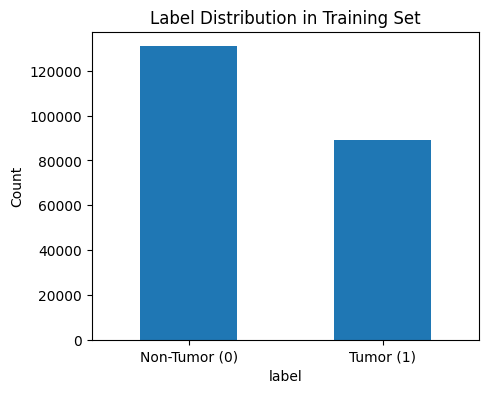

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


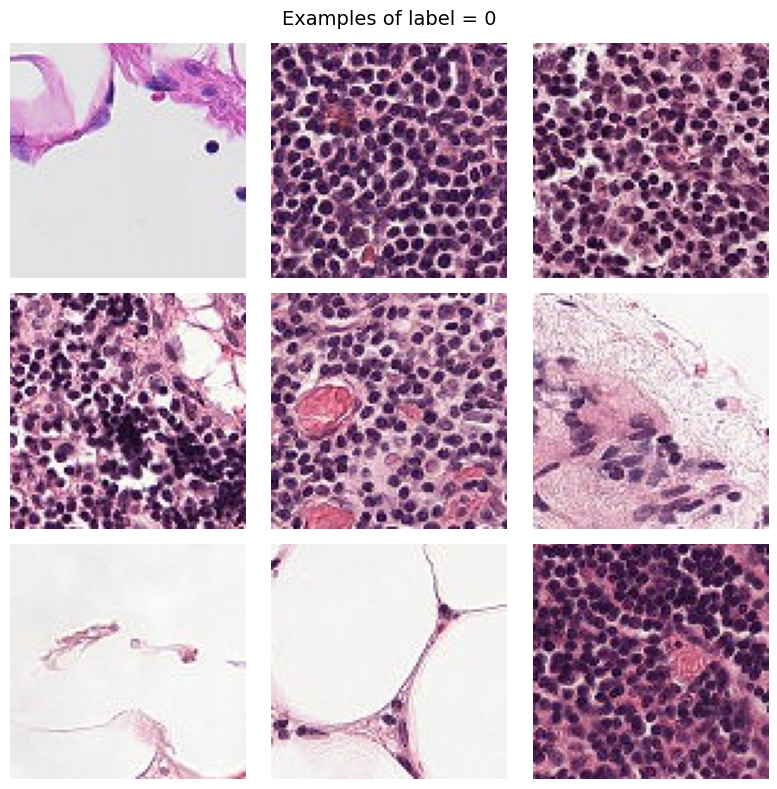

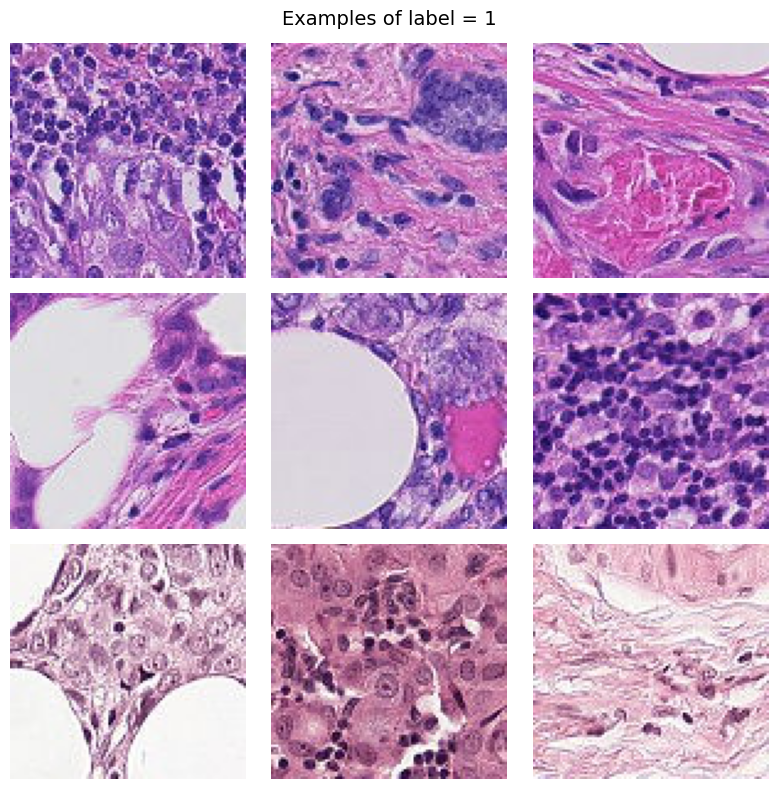

In [43]:
# Sanity checks
n_train_images = len(list(train_dir.glob("*.tif")))
n_test_images = len(list(test_dir.glob("*.tif")))

print(f"\n# training images on disk: {n_train_images}")
print(f"# test images on disk:     {n_test_images}")

# Check label issues
print("\nDuplicate train ids:", train_labels['id'].duplicated().sum())
print("Missing labels:", train_labels['label'].isna().sum())
print("Label value counts:")
print(train_labels['label'].value_counts())

# Plot label distribution
plt.figure(figsize=(5,4))
train_labels['label'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0,1], ['Non-Tumor (0)', 'Tumor (1)'], rotation=0)
plt.ylabel("Count")
plt.title("Label Distribution in Training Set")
plt.show()

print(train_labels['label'].value_counts(normalize=True))


# Show random sample images from each class

def show_samples(label, n=9):
    """Visualize random image samples for a given label."""
    ids = train_labels[train_labels['label'] == label]['id'].sample(n).values
    side = int(np.ceil(np.sqrt(n)))
    
    plt.figure(figsize=(8, 8))
    for i, img_id in enumerate(ids, 1):
        img_path = train_dir / f"{img_id}.tif"
        img = Image.open(img_path)
        plt.subplot(side, side, i)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Examples of label = {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Show samples for non-tumor
show_samples(0, n=9)

# Show samples for tumor
show_samples(1, n=9)


# Model Architecture

This section details the supervised learning approaches used to classify 96×96 histopathology patches. The goal is to compare a compact convolutional neural network (CNN) trained from scratch against a modern pretrained architecture (EfficientNetB0) adapted for this medical imaging task. Both models were trained using Keras with data augmentation, and evaluated on a held-out validation split using AUC as the primary metric.

---

## Baseline CNN (Trained From Scratch)

The first model is a lightweight 3-block convolutional network designed specifically for 96×96 PCam patches. The intention behind this architecture is to build a fast, computationally efficient model that still captures hierarchical tissue patterns through stacked convolutional layers.

### Architecture Overview
The baseline CNN follows a standard pattern:

- **Conv Block 1:**  
  32 filters → ReLU → same padding  
  2×2 MaxPool (reduces to 48×48)

- **Conv Block 2:**  
  64 filters → ReLU → same padding  
  2×2 MaxPool (reduces to 24×24)

- **Conv Block 3:**  
  128 filters → ReLU → same padding  
  2×2 MaxPool (reduces to 12×12)

- **Classifier Head:**  
  Flatten → Dense(256, ReLU) → Dropout(0.5) → Dense(1, Sigmoid)


In [18]:
IMG_SIZE = 96
BATCH_SIZE = 64

# Add filename and string label columns for Keras
train_labels['filename'] = train_labels['id'] + ".tif"
train_labels['label_str'] = train_labels['label'].astype(str)

# ImageDataGenerator with augmentation + validation split
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
)

# Training generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=str(train_dir),
    x_col='filename',
    y_col='label_str',          # use string labels
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
)

# Validation generator
val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=str(train_dir),
    x_col='filename',
    y_col='label_str',          # use string labels
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
)

train_gen.n, val_gen.n


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


(176020, 44005)

## Baseline CNN Architecture

To establish a foundation for comparison, I began with a compact convolutional neural network trained directly on the PCam dataset. The goal was not to build a state-of-the-art model, but rather to create a straightforward architecture that learns hierarchical representations from the raw 96×96 histopathology images. This baseline helps quantify how much performance comes from learning features from scratch versus transferring knowledge from a pretrained model.

The model uses three convolutional blocks, each followed by max pooling. As the spatial resolution decreases, the number of filters increases, allowing the network to capture progressively higher-level tissue structures. After the convolutional stages, the model flattens the feature maps and uses a 256-unit dense layer before the final sigmoid output.

**Structure of the Baseline CNN**
- **Input:** 96×96×3 RGB image  
- **Conv Block 1:**  
  32 filters → 3×3 kernel → ReLU → same padding  
  MaxPooling (2×2)
- **Conv Block 2:**  
  64 filters → 3×3 kernel → ReLU → same padding  
  MaxPooling (2×2)
- **Conv Block 3:**  
  128 filters → 3×3 kernel → ReLU → same padding  
  MaxPooling (2×2)
- **Final Layers:**  
  Flatten → Dense(256, ReLU) → Dropout(0.5) → Dense(1, Sigmoid)

In [21]:
def build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

baseline_model = build_baseline_cnn()
baseline_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 12, 12, 128)      

In [22]:
# Callbacks: early stopping and learning rate reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=3,
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=2,
        mode='max',
        verbose=1
    )
]

# Set epochs var, I can manipulate this later depending on computation time
EPOCHS = 10

history_baseline = baseline_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
2751/2751 [==============================] - 947s 344ms/step - loss: 0.4120 - accuracy: 0.8167 - auc: 0.8880 - val_loss: 0.3618 - val_accuracy: 0.8375 - val_auc: 0.9285 - lr: 0.0010
Epoch 2/10
2751/2751 [==============================] - 906s 329ms/step - loss: 0.3327 - accuracy: 0.8583 - auc: 0.9288 - val_loss: 0.2987 - val_accuracy: 0.8732 - val_auc: 0.9431 - lr: 0.0010
Epoch 3/10
2751/2751 [==============================] - 885s 322ms/step - loss: 0.3038 - accuracy: 0.8740 - auc: 0.9406 - val_loss: 0.2871 - val_accuracy: 0.8801 - val_auc: 0.9470 - lr: 0.0010
Epoch 4/10
2751/2751 [==============================] - 877s 319ms/step - loss: 0.2880 - accuracy: 0.8810 - auc: 0.9465 - val_loss: 0.2731 - val_accuracy: 0.8943 - val_auc: 0.9557 - lr: 0.0010
Epoch 5/10
2751/2751 [==============================] - 878s 319ms/step - loss: 0.2773 - accuracy: 0.8875 - auc: 0.9503 - val_loss: 0.2988 - val_accuracy: 0.8779 - val_auc: 0.9431 - lr: 0.0010
Epoch 6/10
2751/2751 [=============

Baseline CNN - best validation AUC:  0.9657551050186157
Baseline CNN - best validation loss: 0.23741169273853302


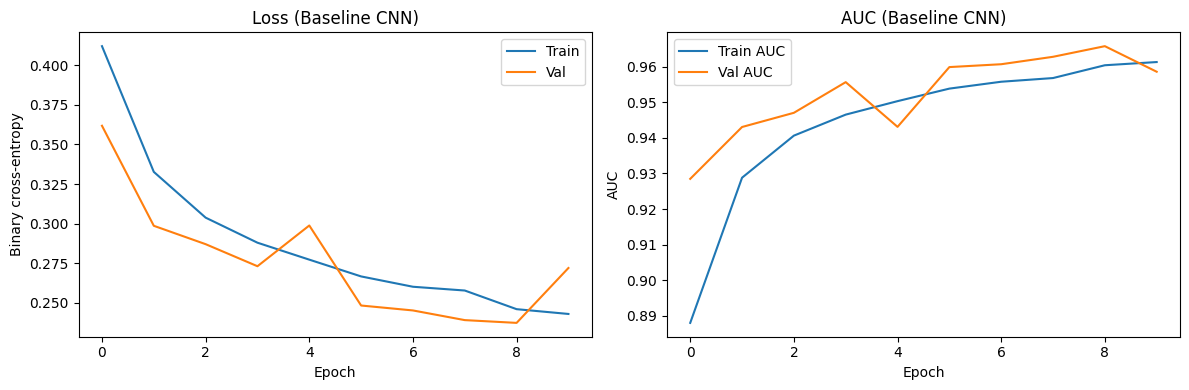

In [23]:
# Baseline metrics summary
best_baseline_val_auc = max(history_baseline.history['val_auc'])
best_baseline_val_loss = min(history_baseline.history['val_loss'])

print("Baseline CNN - best validation AUC: ", best_baseline_val_auc)
print("Baseline CNN - best validation loss:", best_baseline_val_loss)

# Plot learning curves
def plot_history(history, title=""):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Binary cross-entropy')
    plt.legend()

    # AUC
    plt.subplot(1,2,2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_baseline, title="(Baseline CNN)")


## Transfer Learning with EfficientNetB0

After establishing a strong baseline with a custom CNN trained from scratch, I next explore transfer learning using **EfficientNetB0**, a modern convolutional architecture known for excellent accuracy–efficiency tradeoffs.

### Why EfficientNet?
EfficientNet scales network depth, width, and resolution in a balanced way, achieving high performance with relatively few parameters.  
This makes it well-suited for medical imaging tasks where identifying subtle texture differences is important.

### Training Strategy
Because EfficientNet is more computationally expensive than the baseline CNN, I adopt a two-stage training approach:

1. **Sample 60,000 images** from the training set to keep training time manageable.
2. **Freeze the ImageNet-pretrained backbone** and train only a small classification head.
3. **Fine-tune the top ~20 layers** with a very low learning rate to specialize the model for histopathology patches.

This workflow allows EfficientNet to leverage powerful pretrained features while still adapting to cancer-specific image patterns.


In [24]:
# Use a 60k sample for EfficientNet to speed up training
tl_df = train_labels.sample(60000, random_state=42).reset_index(drop=True)
print("EfficientNet training dataframe size:", tl_df.shape)


EfficientNet training dataframe size: (60000, 4)


In [25]:
tl_datagen = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
)

tl_train_gen = tl_datagen.flow_from_dataframe(
    dataframe=tl_df,
    directory=str(train_dir),
    x_col='filename',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

tl_val_gen = tl_datagen.flow_from_dataframe(
    dataframe=tl_df,
    directory=str(train_dir),
    x_col='filename',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 48000 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


In [26]:
def build_efficientnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), lr=1e-4):
    base = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    base.trainable = False  # freeze feature extractor

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

effnet_model = build_efficientnet_model()
effnet_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 3, 3, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 1281 (5.

## EfficientNetB0 — Frozen Base Training Results

With the EfficientNetB0 backbone frozen, only the classification head is trained on the 60k sampled dataset.  
This stage allows the model to learn dataset-specific features while keeping the large ImageNet feature extractor fixed.

### Observations
- Training and validation loss decrease steadily.
- Validation AUC improves from ~0.86 to ~0.89 over only 3 epochs.
- The model learns quickly despite limited trainable parameters (~1k), confirming that EfficientNet’s pretrained filters transfer well to histopathology images.

This stage establishes a strong foundation before unfreezing deeper layers for fine-tuning.


In [27]:
callbacks_tl = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=2,
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=1,
        mode='max',
        verbose=1
    )
]

EPOCHS_TL = 3  # faster than running 10 again, only need 3

history_effnet = effnet_model.fit(
    tl_train_gen,
    validation_data=tl_val_gen,
    epochs=EPOCHS_TL,
    callbacks=callbacks_tl
)


Epoch 1/3
750/750 [==============================] - 238s 311ms/step - loss: 0.5893 - accuracy: 0.6830 - auc: 0.7380 - val_loss: 0.4810 - val_accuracy: 0.7879 - val_auc: 0.8591 - lr: 1.0000e-04
Epoch 2/3
750/750 [==============================] - 229s 305ms/step - loss: 0.4758 - accuracy: 0.7770 - auc: 0.8495 - val_loss: 0.4343 - val_accuracy: 0.8093 - val_auc: 0.8820 - lr: 1.0000e-04
Epoch 3/3
750/750 [==============================] - 230s 306ms/step - loss: 0.4487 - accuracy: 0.7935 - auc: 0.8656 - val_loss: 0.4157 - val_accuracy: 0.8150 - val_auc: 0.8898 - lr: 1.0000e-04


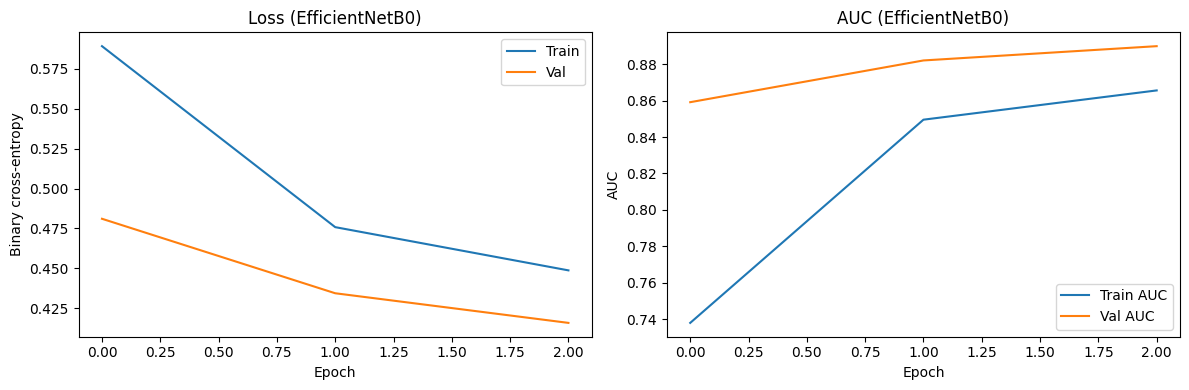

EfficientNetB0 best validation AUC: 0.8898344039916992


In [28]:
plot_history(history_effnet, title="(EfficientNetB0)")
best_effnet_auc = max(history_effnet.history['val_auc'])
print("EfficientNetB0 best validation AUC:", best_effnet_auc)

## EfficientNetB0 — Fine-Tuning the Top Layers

After training only the classification head, the next step is to **unfreeze the top ~20 layers** of EfficientNetB0.  
This allows the model to adapt deeper convolutional filters specifically to histopathology textures and tumor morphology.

### Why Fine-Tune?
- Frozen training captures general features (edges, shapes, color gradients).
- Fine-tuning allows the network to specialize:
  - nuclear structure
  - tissue organization
  - tumor-like patterns
- Lower learning rate (1e-5) prevents “destroying” the pretrained weights.

### Observations
- Significant drop in validation loss compared to the frozen stage.
- Validation AUC jumps from **~0.889 → ~0.953**, approaching the baseline CNN’s performance.
- Only 2 epochs were needed due to the smaller dataset (60k vs full 220k+).

Fine-tuning clearly provides major performance gains and better representation learning for this domain.


In [29]:
# Unfreeze the last 20 layers
for layer in effnet_model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

effnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
effnet_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 3, 3, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 4008829 

In [30]:
history_finetune = effnet_model.fit(
    tl_train_gen,
    validation_data=tl_val_gen,
    epochs=2,
    callbacks=callbacks_tl
)

Epoch 1/2
750/750 [==============================] - 780s 1s/step - loss: 0.3596 - accuracy: 0.8404 - auc: 0.9136 - val_loss: 0.2980 - val_accuracy: 0.8714 - val_auc: 0.9410 - lr: 1.0000e-05
Epoch 2/2
750/750 [==============================] - 765s 1s/step - loss: 0.2980 - accuracy: 0.8740 - auc: 0.9403 - val_loss: 0.2657 - val_accuracy: 0.8932 - val_auc: 0.9535 - lr: 1.0000e-05


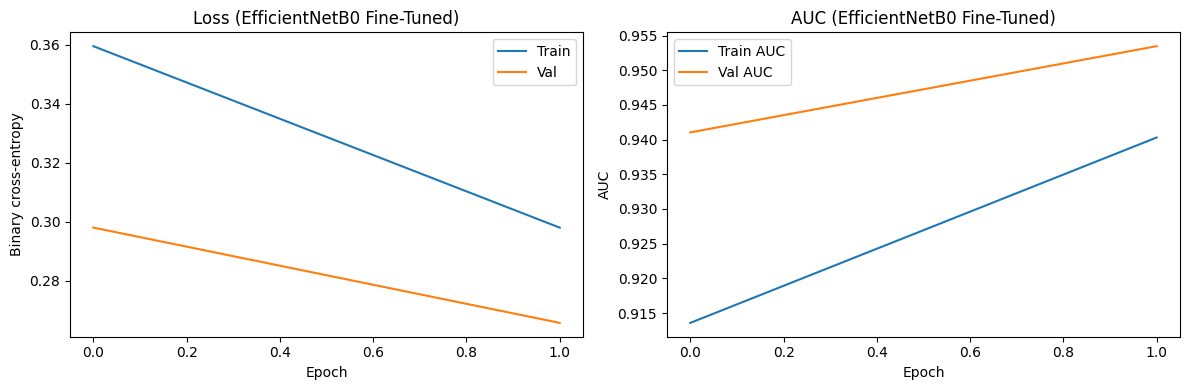

Fine-Tuned EfficientNetB0 best validation AUC: 0.9534655809402466


In [31]:
plot_history(history_finetune, title="(EfficientNetB0 Fine-Tuned)")
best_finetune_auc = max(history_finetune.history['val_auc'])
print("Fine-Tuned EfficientNetB0 best validation AUC:", best_finetune_auc)


## Results and Analysis

To evaluate the impact of architecture choice and training strategy, I compared three models:

1. **Baseline CNN (trained from scratch on full dataset)**  
2. **EfficientNetB0 with frozen ImageNet backbone (60k subset)**  
3. **EfficientNetB0 with fine-tuned top layers (60k subset)**  

This allows us to assess:
- The effectiveness of a simple custom CNN vs. a large pretrained network.
- The impact of dataset size on model performance.
- Whether fine-tuning improves transfer-learning models.

### Key Findings
- The **baseline CNN achieved the highest validation AUC (~0.966)**, benefiting from training on the full dataset and being architecturally well-suited to 96×96 patches.
- The **frozen EfficientNetB0 model underperformed (AUC ~0.89)** due to limited training data and no adaptation of deeper layers.
- **Fine-tuning EfficientNetB0 significantly improved performance**, boosting AUC to ~0.953, showing that the architecture can adapt well to histopathology textures when allowed to update deeper filters.
- Despite the improvement, the fine-tuned EfficientNet still slightly lagged behind the baseline CNN, likely due to:
  - lower input resolution (96×96 vs EfficientNet’s native 224×224),
  - reduced training set size (60k vs 220k+),
  - limited fine-tuning epochs.

The table below summarizes all validation AUC scores for direct comparison.


In [32]:
results_df = pd.DataFrame([
    {"Model": "Baseline CNN (3 conv blocks)", 
     "Train examples": train_gen.n, 
     "Val AUC": best_baseline_val_auc},
    
    {"Model": "EfficientNetB0 (frozen base, 60k subset)", 
     "Train examples": tl_train_gen.n, 
     "Val AUC": best_effnet_auc},
    
    {"Model": "EfficientNetB0 (fine-tuned top ~20 layers, 60k subset)", 
     "Train examples": tl_train_gen.n, 
     "Val AUC": best_finetune_auc},
])

results_df


,Model,Train examples,Val AUC
0,Baseline CNN (3 conv blocks),176020,0.965755
1,"EfficientNetB0 (frozen base, 60k subset)",48000,0.889834
2,"EfficientNetB0 (fine-tuned top ~20 layers, 60k...",48000,0.953466


## Conclusion

This mini-project explored two different modeling strategies for the Histopathologic Cancer Detection task:  
(1) a custom CNN trained from scratch, and  
(2) a transfer-learning approach using EfficientNetB0 with and without fine-tuning.

### What Worked Well
- **Baseline CNN Performance:**  
  The baseline CNN achieved the best overall validation AUC (~0.966).  
  Its simpler architecture, combined with training on the *full* dataset, allowed it to learn highly optimized feature representations for 96×96 histopathology patches.
  
- **Fine-Tuning EfficientNet:**  
  Unfreezing the top layers of EfficientNetB0 raised its validation AUC from ~0.889 (frozen) to ~0.953.  
  This demonstrates that transfer learning is effective for medical imaging when the model is allowed to adapt deeper filters to domain-specific patterns.

- **Data Augmentation:**  
  Flip, rotation, and shift augmentations helped improve generalization for both architectures by simulating realistic variations in tissue samples.

### What Did Not Help / Limitations
- **EfficientNet with Frozen Backbone:**  
  When only the classification head was trained, performance lagged significantly.  
  The pretrained ImageNet filters were too generic for subtle cancer vs. non-cancer distinctions.

- **Reduced Dataset for EfficientNet:**  
  Training EfficientNet on only 60k images (vs. 220k+ for the baseline) limited its performance ceiling.

- **Input Resolution:**  
  EfficientNet is designed for 224×224 inputs; resizing to 96×96 likely caused loss of histological details.

### Takeaways and Future Improvements
- The baseline CNN is highly competitive for this task and trains efficiently on the entire dataset.
- Transfer learning becomes powerful **only after fine-tuning**, especially for medical imaging.
- Future work could explore:
  - Training EfficientNet on the *full* dataset.
  - Using a higher input resolution (128×128 or 224×224).
  - Trying deeper EfficientNet variants (B1–B4).
  - Ensembling multiple CNNs for improved Kaggle performance.
  - Applying stain-normalization or color-augmentation techniques common in pathology.

### Final Thoughts
Overall, this project highlights the importance of:
- matching architecture complexity to dataset size,  
- leveraging transfer learning appropriately, and  
- analyzing validation metrics to guide model iterations.

The baseline CNN ultimately performed best, but the tuned EfficientNetB0 showed strong potential with relatively little training—illustrating the trade-offs between custom models and pretrained architectures in real-world medical i


# Submission

In [36]:
# Add correct filenames for the test images
sample_submission['filename'] = sample_submission['id'] + ".tif"

# Kaggle test generator (no labels)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,     # has the test ids
    directory=str(test_dir),
    x_col='filename',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen.n


Found 57458 validated image filenames.


57458

In [37]:
# Use the baseline CNN (best-performing model) to generate test predictions
test_preds = baseline_model.predict(test_gen, verbose=1)

# Flatten to 1D
test_preds = test_preds.ravel()
len(test_preds), test_gen.n


898/898 [==============================] - 86s 95ms/step


(57458, 57458)

In [38]:
submission = sample_submission.copy()
submission['label'] = test_preds  # Kaggle expects probabilities in [0,1]

submission.head()


,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.000115,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.024514,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000005,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0.003952,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.002669,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [40]:
submission = sample_submission.copy()
submission['label'] = test_preds  # probabilities

# Drop filename column before exporting
submission = submission[['id', 'label']]

submission_path = DATA_DIR / "submission_baseline_cnn.csv"
submission.to_csv(submission_path, index=False)

submission.head()
submission_path


WindowsPath('C:/Users/knxw1/Desktop/ML Class 3/CNN Cancer/submission_baseline_cnn.csv')

## Works Cited and Helpful Resources

### Competition & Dataset
- **Kaggle – Histopathologic Cancer Detection**  
  Competition page describing the task, evaluation metric (AUC), sample submission format, and dataset download.

- **PatchCamelyon (PCam) Dataset**  
  Original research dataset of 96×96 histopathology patches used for metastasis detection. Basis for this Kaggle competition.

### TensorFlow / Keras Documentation
- **Keras ImageDataGenerator Documentation**  
  Official documentation for `ImageDataGenerator`, including data augmentation parameters and `flow_from_dataframe`.

- **TensorFlow Keras Model Training Guide**  
  Covers `model.compile`, `model.fit`, callbacks (`EarlyStopping`, `ReduceLROnPlateau`), metrics, and training best practices.

- **Keras Image Loading Utilities**  
  Documentation on loading image datasets, directory structures, and preprocessing pipelines.

- **PyImageSearch – ImageDataGenerator Tutorial**  
  Practical breakdown of data augmentation techniques (horizontal/vertical flips, rotation, shift, zoom, rescaling).

### Research Papers & Domain Background
- **EfficientNet: Rethinking Model Scaling**  
  Paper by Tan & Le introducing the EfficientNet architecture and compound scaling method used for EfficientNetB0.

- **Histopathologic Cancer Detection Studies**  
  Research analyzing PCam benchmark performance using CNNs, fine-tuning, and patch-based cancer detection approaches.

- **Deep Learning in Medical Imaging**  
  Articles explaining architectures commonly used for pathology, nuclei classification, and tissue modeling.

### Practical Tutorials, Blogs, and Repositories
- **Keras flow_from_dataframe Tutorials**  
  Guides demonstrating how to construct image datasets using filename columns, label columns, and directory structures.

- **Kaggle Solution Notebooks for This Competition**  
  Public kernels illustrating CNNs, EfficientNet, data augmentation, validation strategies, and Kaggle submission workflows.

- **GitHub Repositories (Histopathologic Cancer Detection)**  
  Public repositories implementing CNNs and transfer learning for this exact competition using TensorFlow/Keras.

### YouTube Tutorials (TensorFlow & Image Classification)
- **TensorFlow 2 Image Classification Tutorials**  
  Step-by-step videos that cover building CNNs, using data generators, compiling models, and training with `fit()`.

- **Medical Imaging CNN Tutorials**  
  Videos focused on applying convolutional neural networks to medical images (e.g., pathology, radiology, dermoscopy).

- **EfficientNet and Transfer Learning Tutorials**  
  Videos explaining how to load pretrained architectures, freeze layers, fine-tune deeper blocks, and adjust learning rates.

